In [1]:
%matplotlib inline
import os
import collections
import torch
import torchvision
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt

from SUNRGBDLoader import *

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [51]:
import sys, os
import torch
import visdom
import argparse
import timeit
import numpy as np
import scipy.misc as misc
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.autograd import Variable
from torch.utils import data
from tqdm import tqdm

from ptsemseg.models import get_model
from ptsemseg.loader import get_loader, get_data_path
from ptsemseg.utils import convert_state_dict

def test(args):
    model_file_name = os.path.split(args.model_path)[1]
    model_name = model_file_name[:model_file_name.find('_')]
    
    img = misc.imread(args.color_img_path)

    data_path = '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD(meta)/'
    loader = SUNRGBDLoader(data_path, is_transform=True, img_norm=args.img_norm)
    n_classes = loader.n_classes
    
    resized_img = misc.imresize(img, (loader.img_size[0], loader.img_size[1]), interp='bicubic')

    orig_size = img.shape[:-1]
    if model_name in ['pspnet', 'icnet', 'icnetBN']:
        img = misc.imresize(img, (orig_size[0]//2*2+1, orig_size[1]//2*2+1)) # uint8 with RGB mode, resize width and height which are odd numbers
    else:
        img = misc.imresize(img, (loader.img_size[0], loader.img_size[1]))
    img = img[:, :, ::-1]
    img = img.astype(np.float64)
    img -= loader.mean
    if args.img_norm:
        img = img.astype(float) / 255.0
    # NHWC -> NCHW
    img = img.transpose(2, 0, 1)
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img).float()

    # Setup Model
    model = get_model(model_name, n_classes, version=args.dataset)
    state = convert_state_dict(torch.load(args.model_path)['model_state'])
    model.load_state_dict(state)
    model.eval()

    if torch.cuda.is_available():
        model.cuda(0)
        images = Variable(img.cuda(0), volatile=True)
    else:
        images = Variable(img, volatile=True)

    outputs = model(images)
    #outputs = F.softmax(outputs, dim=1)

    pred = np.squeeze(outputs.data.max(1)[1].cpu().numpy(), axis=0)
    if model_name in ['pspnet', 'icnet', 'icnetBN']:
        pred = pred.astype(np.float32)
        pred = misc.imresize(pred, orig_size, 'nearest', mode='F') # float32 with F mode, resize back to orig_size
    decoded = loader.decode_segmap(pred)
    print('Classes found: ', np.unique(pred))
    misc.imsave(args.out_path, decoded)
    plt.imshow(decoded)
    print("Segmentation Mask Saved at: {}".format(args.out_path))

In [47]:
def transform(color_img, depth_img):
    color_img = m.imresize(color_img, (480, 640)) # uint8 with RGB mode
    color_img = color_img[:, :, ::-1] # RGB -> BGR
    color_img = color_img.astype(np.float64)
    color_img -= np.array([104.00699, 116.66877, 122.67892])
    color_img = color_img.astype(float) / 255.0
    # NHWC -> NCHW
    color_img = color_img.transpose(2, 0, 1)
    color_img = np.expand_dims(color_img, 0)

    depth_img = m.imresize(depth_img, (480,640))
    depth_img = depth_img.astype(np.float64)
    depth_img = depth_img[np.newaxis,:]
    depth_img -= 123.901
    depth_img = depth_img.astype(float) / 255.0
    depth_img = np.expand_dims(depth_img, 0)

    color_img = torch.from_numpy(color_img).float()
    depth_img = torch.from_numpy(depth_img).float()
    
    return color_img, depth_img
    
def rgbd_test(args):
    model_file_name = os.path.split(args.model_path)[1]
    model_name = 'fcn8s_with_rgbd'

    color_img = misc.imread(args.color_img_path)
    depth_img = misc.imread(args.depth_img_path)

    data_path = '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD(meta)/'
    loader = SUNRGBDLoader(data_path, is_transform=True, img_norm=args.img_norm)
    n_classes = loader.n_classes

    color_img, depth_img = transform(color_img, depth_img)

    # Setup Model
    model = get_model(model_name, n_classes, version=args.dataset)
    state = convert_state_dict(torch.load(args.model_path)['model_state'])
    model.load_state_dict(state)
    model.eval()

    model.cuda()
    color_img = Variable(color_img.cuda(), volatile=True)
    depth_img = Variable(depth_img.cuda(), volatile=True)

    outputs = model(color_img,depth_img)
    #outputs = F.softmax(outputs, dim=1)

    pred = np.squeeze(outputs.data.max(1)[1].cpu().numpy(), axis=0)
    decoded = loader.decode_segmap(pred)
    print('Classes found: ', np.unique(pred))
    misc.imsave(args.out_path, decoded)
    plt.imshow(decoded)
    print("Segmentation Mask Saved at: {}".format(args.out_path))

In [43]:
parser = argparse.ArgumentParser(description='Params')
parser.add_argument('--model_path', nargs='?', type=str, default='fcn8s_pascal_1_26.pkl', 
                    help='Path to the saved model')
parser.add_argument('--dataset', nargs='?', type=str, default='pascal', 
                    help='Dataset to use [\'pascal, camvid, ade20k etc\']')

parser.add_argument('--img_norm', dest='img_norm', action='store_true', 
                    help='Enable input image scales normalization [0, 1] | True by default')
parser.add_argument('--no-img_norm', dest='img_norm', action='store_false', 
                    help='Disable input image scales normalization [0, 1] | True by default')
parser.set_defaults(img_norm=True)

parser.add_argument('--dcrf', dest='dcrf', action='store_true', 
                    help='Enable DenseCRF based post-processing | False by default')
parser.add_argument('--no-dcrf', dest='dcrf', action='store_false', 
                    help='Disable DenseCRF based post-processing | False by default')
parser.set_defaults(dcrf=False)

parser.add_argument('--color_img_path', nargs='?', type=str, default=None, help='Path of the input color image')
parser.add_argument('--depth_img_path', nargs='?', type=str, default=None, help='Path of the input depth image')
parser.add_argument('--out_path', nargs='?', type=str, default=None, help='Path of the output segmap')

_StoreAction(option_strings=['--out_path'], dest='out_path', nargs='?', const=None, default=None, type=<class 'str'>, choices=None, help='Path of the output segmap', metavar=None)

/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  3  5  6  7 12]
Segmentation Mask Saved at: output.png


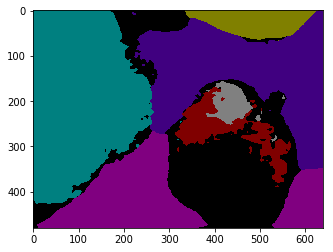

In [60]:
args = parser.parse_args('--model_path fcn8s_SUNRGBD_best_model.pkl --color_img_path test_color.jpg --out_path output.png'.split(' '))
test(args)

/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  3  4  5  6  7 12]
Segmentation Mask Saved at: output.png


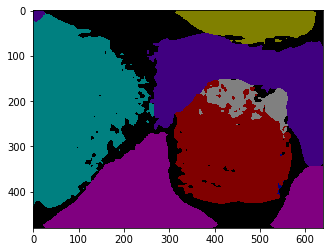

In [61]:
args = parser.parse_args('--model_path fcn8s_with_rgbd_SUNRGBD_best_model.pkl --color_img_path test_color.jpg --depth_img_path test_depth.png --out_path output.png'.split(' '))
rgbd_test(args)